In [1]:
#Importing Functions and Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import pydataset as data

#Importing pre-written scripts to streamline data acquisition and cleaning:
from acquire import get_zillow_data
from prepare import clean_telco_data, prep_telco_data
from env import get_db_url
from stats_toolkit import significance_test
from wrangle import wrangle_zillow, clearing_fips

In [2]:
df = get_zillow_data()

# Wrangle Stuff:

In [3]:
#Acquire Data:
df = get_zillow_data()

def clearing_fips(df):
    '''This function takes in a DataFrame of unprepared Zillow information and generates a new
    'county' column, with the county name based on the FIPS code. Drops the 'fips' column and returns
    the new DataFrame.
    '''
    # create a list of our conditions
    fips = [
        (df['fips'] == 6037.0),
        (df['fips'] == 6059.0),
        (df['fips'] == 6111.0)
        ]
    # create a list of the values we want to assign for each condition
    counties = ['Los Angeles County', 'Orange County', 'Ventura County']
    # create a new column and use np.select to assign values to it using our lists as arguments
    df['county'] = np.select(fips, counties)
    df = df.drop(columns = 'fips')
    return df

#Dropping Null Values:
df = df.dropna()

#Dropping Listings that have 0.0 bathrooms, 0.0 bedrooms, and are under the 120 sqft legal minimum as required by California to be considered a residence:
df = df.drop(df[(df.bedroomcnt == 0.0) & (df.bathroomcnt == 0.0) & (df.calculatedfinishedsquarefeet < 120.0)].index)

#Converting Certain Columns to Integers to Improve Performance:
df.astype({'bedroomcnt' : int, 'yearbuilt': int})

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusedesc
4,4,2.0,3633.0,296425.0,2005,6941.39,6037.0,Single Family Residential
6,3,4.0,1620.0,847770.0,2011,10244.94,6037.0,Single Family Residential
7,3,2.0,2077.0,646760.0,1926,7924.68,6037.0,Single Family Residential
11,0,0.0,1200.0,5328.0,1972,91.60,6037.0,Single Family Residential
14,0,0.0,171.0,6920.0,1973,255.17,6037.0,Single Family Residential
...,...,...,...,...,...,...,...,...
2152856,4,4.0,4375.0,422400.0,2015,13877.56,6037.0,Single Family Residential
2152858,4,3.0,2262.0,960756.0,2015,13494.52,6059.0,Single Family Residential
2152859,4,4.5,3127.0,536061.0,2014,6244.16,6059.0,Single Family Residential
2152861,3,2.5,1974.0,424353.0,2015,5302.70,6059.0,Single Family Residential


# Taking a Quick Look at the Data:

In [4]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusedesc
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0,Single Family Residential
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0,Single Family Residential
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0,Single Family Residential
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0,Single Family Residential
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0,Single Family Residential


In [5]:
df.dtypes

bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
yearbuilt                       float64
taxamount                       float64
fips                            float64
propertylandusedesc              object
dtype: object

In [6]:
df.astype({'bedroomcnt' : int, 'yearbuilt': int, 'fips': int})

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusedesc
4,4,2.0,3633.0,296425.0,2005,6941.39,6037,Single Family Residential
6,3,4.0,1620.0,847770.0,2011,10244.94,6037,Single Family Residential
7,3,2.0,2077.0,646760.0,1926,7924.68,6037,Single Family Residential
11,0,0.0,1200.0,5328.0,1972,91.60,6037,Single Family Residential
14,0,0.0,171.0,6920.0,1973,255.17,6037,Single Family Residential
...,...,...,...,...,...,...,...,...
2152856,4,4.0,4375.0,422400.0,2015,13877.56,6037,Single Family Residential
2152858,4,3.0,2262.0,960756.0,2015,13494.52,6059,Single Family Residential
2152859,4,4.5,3127.0,536061.0,2014,6244.16,6059,Single Family Residential
2152861,3,2.5,1974.0,424353.0,2015,5302.70,6059,Single Family Residential


In [7]:
df.columns.tolist()

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt',
 'taxamount',
 'fips',
 'propertylandusedesc']

In [8]:
df.shape[0]

2140133

In [9]:
df.fips.unique()

array([6037., 6059., 6111.])

# Creating New 'County' column based on 'fips'

In [10]:
def clearing_fips(df):
    '''This function takes in a DataFrame of unprepared Zillow information and generates a new
    'county' column, with the county name based on the FIPS code. Drops the 'fips' column and returns
    the new DataFrame.
    '''
    # create a list of our conditions
    fips = [
        (df['fips'] == 6037.0),
        (df['fips'] == 6059.0),
        (df['fips'] == 6111.0)
        ]
    # create a list of the values we want to assign for each condition
    counties = ['Los Angeles County', 'Orange County', 'Ventura County']
    # create a new column and use np.select to assign values to it using our lists as arguments
    df['county'] = np.select(fips, counties)
    df = df.drop(columns = 'fips')
    return df

clearing_fips(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,propertylandusedesc,county
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,Single Family Residential,Los Angeles County
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,Single Family Residential,Los Angeles County
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,Single Family Residential,Los Angeles County
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,Single Family Residential,Los Angeles County
14,0.0,0.0,171.0,6920.0,1973.0,255.17,Single Family Residential,Los Angeles County
...,...,...,...,...,...,...,...,...
2152856,4.0,4.0,4375.0,422400.0,2015.0,13877.56,Single Family Residential,Los Angeles County
2152858,4.0,3.0,2262.0,960756.0,2015.0,13494.52,Single Family Residential,Orange County
2152859,4.0,4.5,3127.0,536061.0,2014.0,6244.16,Single Family Residential,Orange County
2152861,3.0,2.5,1974.0,424353.0,2015.0,5302.70,Single Family Residential,Orange County


In [11]:
df.county.value_counts()

Los Angeles County    1425105
Orange County          552057
Ventura County         162971
Name: county, dtype: int64

In [12]:
# Dropping 'fips' column:
df.drop(columns = 'fips')

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,propertylandusedesc,county
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,Single Family Residential,Los Angeles County
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,Single Family Residential,Los Angeles County
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,Single Family Residential,Los Angeles County
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,Single Family Residential,Los Angeles County
14,0.0,0.0,171.0,6920.0,1973.0,255.17,Single Family Residential,Los Angeles County
...,...,...,...,...,...,...,...,...
2152856,4.0,4.0,4375.0,422400.0,2015.0,13877.56,Single Family Residential,Los Angeles County
2152858,4.0,3.0,2262.0,960756.0,2015.0,13494.52,Single Family Residential,Orange County
2152859,4.0,4.5,3127.0,536061.0,2014.0,6244.16,Single Family Residential,Orange County
2152861,3.0,2.5,1974.0,424353.0,2015.0,5302.70,Single Family Residential,Orange County


# Checking for and Dropping Nulls:

In [13]:
df.isnull().any()

bedroomcnt                      False
bathroomcnt                     False
calculatedfinishedsquarefeet    False
taxvaluedollarcnt               False
yearbuilt                       False
taxamount                       False
fips                            False
propertylandusedesc             False
county                          False
dtype: bool

In [14]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
propertylandusedesc             0
county                          0
dtype: int64

In [15]:
df[df.bedroomcnt.isnull() | df.bathroomcnt.isnull() | df.calculatedfinishedsquarefeet.isnull() | df.taxvaluedollarcnt.isnull() | df.yearbuilt.isnull() | df.taxamount.isnull() | df.fips.isnull()].shape[0]

0

In [16]:
df = df.dropna()

df.shape[0]

2140133

# Looking for Odd Values:

In [17]:
df.bedroomcnt.value_counts(dropna = False, ascending = True)

25.0         1
16.0         2
18.0         3
15.0         5
14.0         7
12.0        12
13.0        15
11.0        34
10.0       118
9.0        290
8.0       1103
0.0       4295
7.0       4792
1.0      22895
6.0      25117
5.0     150671
2.0     334221
4.0     633608
3.0     962944
Name: bedroomcnt, dtype: int64

In [18]:
df.bathroomcnt.value_counts(dropna = False, ascending = True)

19.00         1
19.50         1
32.00         1
14.50         1
12.50         3
11.50         3
1.75          3
17.00         4
20.00         6
18.00         8
16.00        12
10.50        14
0.50         16
15.00        17
14.00        25
13.00        39
9.50         50
12.00        73
8.50        108
11.00       145
10.00       322
7.50        382
9.00        707
6.50       1330
8.00       1681
0.00       4172
7.00       4381
5.50       6201
6.00      10717
4.50      19474
5.00      28306
3.50      28464
1.50      31157
4.00      82039
2.50     142827
1.00     412582
3.00     422398
2.00     942463
Name: bathroomcnt, dtype: int64

In [19]:
# Listings with 0 bedrooms comprise only .2% of the dataset: 
df[df.bedroomcnt == 0.0].shape[0] / df.shape[0]

0.002006884618853127

In [20]:
#Listings with 0 bathrooms comprise only .2% of the dataset:
df[df.bathroomcnt == 0.0].shape[0] / df.shape[0]

0.001949411555263154

In [21]:
#Listings with 0 bedrooms AND 0 bathrooms comprise only .15% of the dataset
df[(df.bedroomcnt == 0.0) & (df.bathroomcnt == 0.0)].shape[0] / df.shape[0]

0.0015153263839209994

In [22]:
df[(df.bedroomcnt == 0.0) & (df.bathroomcnt == 0.0) & (df.calculatedfinishedsquarefeet < 120.0)].shape

(0, 9)

In [23]:
#Listings that have 0.0 bathrooms, 0.0 bedrooms, and are under the 120 sqft legal minimum as required by California to be considered a residence:
df[(df.bedroomcnt == 0.0) & (df.bathroomcnt == 0.0) & (df.calculatedfinishedsquarefeet < 120.0)].sort_values(by = ['taxvaluedollarcnt'], ascending = False)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusedesc,county


In [24]:
df = df.drop(df[(df.bedroomcnt == 0.0) & (df.bathroomcnt == 0.0) & (df.calculatedfinishedsquarefeet < 120.0)].index)

# Visualizing Some of the Data:

<AxesSubplot:xlabel='bedroomcnt', ylabel='taxvaluedollarcnt'>

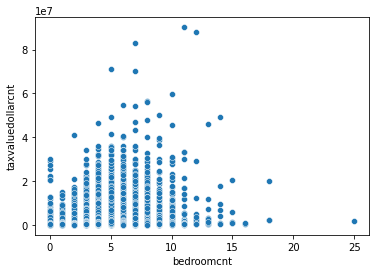

In [25]:
sns.scatterplot(x = df.bedroomcnt, y = df.taxvaluedollarcnt)

<AxesSubplot:xlabel='bathroomcnt', ylabel='taxvaluedollarcnt'>

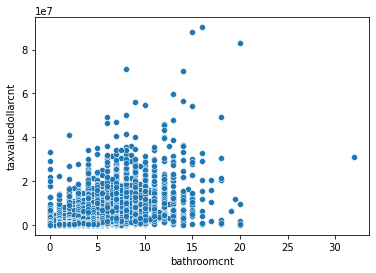

In [26]:
sns.scatterplot(x = df.bathroomcnt, y = df.taxvaluedollarcnt)